# 18 RNN Name Classification

### Utils 

In [12]:
import io
import os
import unicodedata
import string 
import glob 

import torch
import random 

In [19]:
ALL_LETTERS = string.ascii_lowercase + '.,;'
N_LETTERS = len(ALL_LETTERS)
ALL_LETTERS

'abcdefghijklmnopqrstuvwxyz.,;'

In [21]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

In [22]:
unicode_to_ascii('Hello@!12212')

'ello'

In [23]:
def load_data():
    category_lines = {}
    all_categories = []
    
    def find_files(path):
        return glob.glob(path)
    
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line.lower()) for line in lines]
    
    for filename in find_files('data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        
        lines = read_lines(filename)
        category_lines[category] = lines
        
    return category_lines, all_categories

In [24]:
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1 
    return tensor

def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor 

In [44]:
def random_training_example(category_lines, all_categories):
    def random_choice(a):
        rid = random.randint(0, len(a) - 1)
        return a[rid]
    
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

In [25]:
line_to_tensor('Hola')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [26]:
category_lines, all_categories = load_data()
category_lines['Italian'][:5]

['abandonato', 'abatangelo', 'abatantuono', 'abate', 'abategiovanni']

### RNN

In [27]:
import torch 
import torch.nn as nn 
import matplotlib.pyplot as plt

In [47]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size 
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), dim=1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [30]:
category_lines, all_categories = load_data()
n_categories = len(all_categories)
n_categories

18

#### One step

In [32]:
n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()
output, next_hidden = rnn(input_tensor, hidden_tensor)
output.shape, next_hidden.shape

(torch.Size([1, 18]), torch.Size([1, 128]))

#### Sequence

In [39]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

In [37]:
n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()
output, next_hidden = rnn(input_tensor[0], hidden_tensor)
output.shape, next_hidden.shape

(torch.Size([1, 18]), torch.Size([1, 128]))

In [40]:
criteria = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [41]:
def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criteria(output, category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return output, loss.item()

In [42]:
current_loss = 0 
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000

In [53]:
n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

criteria = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

current_loss = 0 
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000

for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss 
    
    if (i + 1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
    
    if (i + 1) % print_steps == 0:
        guess = category_from_output(output)
        correct = 'CORRECT' if guess == category else f'WRONG {category}'
        print(f'{i+1:6d} {(i+1)/n_iters*100:2.0f}% {loss:.4f} {line} / {guess} {correct}')

  5000  5% 2.3348 kunik / Czech CORRECT
 10000 10% 2.1382 kwang / Vietnamese WRONG Korean
 15000 15% 2.2334 rana / Vietnamese WRONG Spanish
 20000 20% 2.0251 kopp / Japanese WRONG Czech
 25000 25% 1.5154 montagne / French CORRECT
 30000 30% 1.1054 masih / Arabic CORRECT
 35000 35% 2.5998 frazer / German WRONG English
 40000 40% 0.2112 chertykov / Russian CORRECT
 45000 45% 4.4147 jelen / English WRONG Polish
 50000 50% 3.3530 delbosque / French WRONG Spanish
 55000 55% 0.4327 huynh / Vietnamese CORRECT
 60000 60% 0.7659 costanzo / Italian CORRECT
 65000 65% 0.7635 redwood / English CORRECT
 70000 70% 0.1356 beaumont / French CORRECT
 75000 75% 1.6581 ariwara / Japanese CORRECT
 80000 80% 0.5603 choi / Korean CORRECT
 85000 85% 0.4320 moon / Korean CORRECT
 90000 90% 1.2294 schneider / German WRONG Dutch
 95000 95% 0.7174 janicek / Czech CORRECT
100000 100% 1.6509 fabian / Irish WRONG French


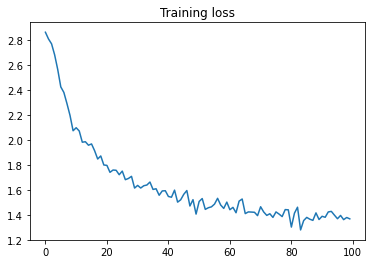

In [54]:
plt.plot(all_losses)
plt.title('Training loss')
plt.show()